# Tempus Data Science Case Study

The goal of this project is to build a predictive model on the Tempus Data Science case study dataset. The data provided contains containing 16,562 features and a single response variable. This is a typical binary classification problem with the goal of creating a function, or model, that can distinguish data taken from the positive (i.e., 1) response set and data taken from the negative (i.e., 0) response set.

The scikit-learn Python framework and the Pandas library are employed to ingest the dataset, build the classification model, and show the model performance. The data is processed and transformed in the Model Inputs section. Three binary classifiers are constructed in the Model Building section, and finally, the performance of the three models is explained in the Model Performance section.

In [97]:
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Notebook Last Run Initiated: 2019-01-30 13:38:16.924013


## Standard Python Modules

In [94]:
from numpy import reshape
from pandas import DataFrame, Series, to_datetime
import xgboost
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score    
from sklearn.feature_selection import SelectFromModel
from transform import transformData

import sys
print(sys.version)

3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


# Model Inputs

In [98]:
from pandas import read_csv
data = read_csv("data.txt", delimiter='\t')
data.shape

(530, 16563)

In [99]:
data.columns

Index(['response', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       ...
       'V16553', 'V16554', 'V16555', 'V16556', 'V16557', 'V16558', 'V16559',
       'V16560', 'V16561', 'V16562'],
      dtype='object', length=16563)

In [100]:
y = data['response']  ## y is the response data also known as the target variable
X = data.drop('response', axis=1)  ## X is the predictor data also known collectively as the feature dataset

Due to the overwhemingly large number of columns it is import to remove features (i.e., columns) with little variance or little correlation with the target. Keeping these columns could easily lead to overfitting. If there were more rows this requirement could be loosened.

In [101]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.1)
print("There are correctly {0} columns in the data".format(X.shape[1]))
X = sel.fit_transform(X)
print("There are now {0} columns in the data".format(X.shape[1]))

There are correctly 16562 columns in the data
There are now 2055 columns in the data


The scikit-learn train/test split function is employed to randomly create mutually exclusive training and testing datasets. If this step were not run it would lead to "leakage" and result in an overestimation of the actual model performance.

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Model Building

Here we create three binary classifier functions that access the underlying algorithms in the scikit-learn and xgboost libraries. The three algoritms are chosen based on previous experience using these models. The simplest and least complex model is Logistic Regression, which has no internal tunable parameters. The Random Forest model is known as an ensemble model that is constructed from a collection, or ensemble, of decision trees created using a random set of features. The third model, Xgboost, is an improved gradient boosted decision tree model this is known to perform extremely well on a wide variety of problems. 

In [103]:
def trainLogReg(X_train, y_train):
    name = 'logreg'
    glm = LogisticRegression()
    model = trainEstimator(name, glm, X_train, y_train)
    return model

In [113]:
def trainRF(X_train, y_train):
    name = 'rf'
    rf = RandomForestClassifier(n_estimators=50)
    model = trainEstimator(name, rf, X_train, y_train)
    return model

In [114]:
def trainXGboost(X_train, y_train):
    name = 'xgb'
    xgb = xgboost.XGBClassifier(n_jobs=1)
    model = trainEstimator(name, xgb, X_train, y_train)
    return model

Train the models without tuning any available hyperparameters. If there were more data, tuning these parameters would likely result in improved models.

In [115]:
logreg = trainLogReg(X_train, y_train)
rf     = trainRF(X_train, y_train)
xgb    = trainXGboost(X_train, y_train)
models = {"logreg": logreg, "xgb": xgb, "rf": rf}

Use the trained models to predict the response on the as-yet-unseen test data. The relative difference between the predicted response and the actual test response serves as the model performance shown in the next section.

In [116]:
perfs = {}
for modelname, model in models.items():
    y_probs  = model.predict_proba(X_test)[:,1]
    y_probs  = Series(data=y_probs, name="predicted")
    y_preds  = model.predict(X_test)
    y_preds  = Series(data=y_preds, name="predicted")
    perfs[modelname] = {"Probs": y_probs, "Preds": y_preds}

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Model Performance

Compute the standard suite of binary classification performance metrics. The most common of these are the true-positive rate (TPR) and fake-positive rate (FPR), which respresent the fraction of events that we correctly and incorrectly assigned to the true response value. From these values, the reciever-operator curve (ROC) can be constructed to visualize the performance of the models and compare them the case of a random and perfect prediction.

In [117]:
modelperfdata = {}
for modelname,modeldata in perfs.items():
    retval = {}
    y_truth = y_test
    y_probs = modeldata['Probs']
    y_preds = modeldata['Preds']
    precision, recall, pr_thresholds = precision_recall_curve(y_truth, y_probs)
    retval["PR"] = {"precision": precision, "recall": recall, "thresholds": pr_thresholds}

    fpr, tpr, roc_thresholds = roc_curve(y_truth, y_probs)
    retval["ROC"] = {"fpr": fpr, "tpr": tpr, "thresholds": roc_thresholds}

    auc = roc_auc_score(y_truth, y_probs)
    retval["AUC"] = auc

    cfm = confusion_matrix(y_truth, y_preds)
    tn, fp, fn, tp = cfm.ravel()
    retval["Confusion"] = {"matrix": cfm, "tn": tn, "tp": tp, "fn": fn, "fp": fp}
    
    modelperfdata[modelname] = retval

Another useful metric is the confusion matrix, which shows the number of true-positive (TP) predictions, false-negative (FN) predictions, true-negative (TN) preduction, and false-positive (FP) prediction.

In [124]:
for modelname, perfdata in modelperfdata.items():
    mat = perfdata["Confusion"]['matrix']
    print("The confusion matrix for {0} is {1}".format(modelname, mat))

The confusion matrix for logreg is [[125   1]
 [ 29  20]]
The confusion matrix for xgb is [[125   1]
 [ 22  27]]
The confusion matrix for rf is [[125   1]
 [ 41   8]]


Plot the ROC curve for each classifier and show the area-under-the-curve (AUC) for each. The AUC is the integral (area) of the ROC curve between 0 and 1. A random prediction model (e.g., coin flip) will have an AUC value of 0.5. A perfect model will have an AUC value of 1, and all other models have values between 0.5 and 1. Models with values closer to 1 are better models (i.e., predict more correct responses) than models with values closer to 0.5 (i.e., predict few correct responses).

The AUC for logreg is 0.82
The AUC for xgb is 0.81
The AUC for rf is 0.81


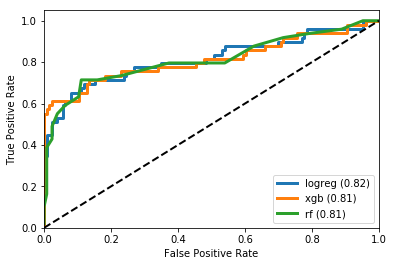

In [119]:
perfdata = retval

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
current_palette = sns.color_palette()
i = 0
for modelname, perfdata in modelperfdata.items():
    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    auc = perfdata['AUC']
    print("The AUC for {0} is {1}".format(modelname, round(auc,2)))
    tpr = perfdata['ROC']['tpr']
    fpr = perfdata['ROC']['fpr']
    plt.plot(fpr, tpr,
             label='{0} ({1:0.2f})'
             ''.format(modelname, auc),
             color=current_palette[i], linestyle='-', linewidth=3)
    i += 1

title = "Receiver Operating Characteristic"
value = "ROC"
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")



The above plot is the ROC curve for each model. The y-axis is the true-positive (correct positive assignment) rate and x-axis is the false-positive (incorrect positve assignment) rate. Curves nearer to the top-left corner are considered good models while models whose curve lies near the dotted line are considered poor models.

# Summary

All three binary classifiers essentially show the same performance as determined from the ROC, AUC, and confusion matrix values. The independent test dataset contained 175 rows and each classifer correclty predicted 125 of the true response values. The classifiers differed slightly in the assignment for TN, FN, and FP. Given the relatively low number of events in the testing data it is difficult to say that one classifier greatly exceeds another one. A much larger training and testing dataset would certainly help to decide which model is best. Additional data would also allow for more features in the training dataset that could improve the overall model performance.

# Additional Code

In [ ]:
def splitDataByKey(pddata, key, targetcol, trainFraction=0.25):
    """
    Split the data into test and train data
    
    Inputs:
      > pddata: the model feature data (DataFrame)
      > key: a key to split the train/test data on
      > targetcol: the name of the target column
      > trainFraction (0.25 by default): fraction of events to use for training
      
    Outputs:
      > Training feature data (DataFrame), Testing feature data (DataFrame), Training target data (Series), Testing target data (Series)
    """
    keydata = [str(x) for x in list(pddata[key].unique())]
    print("There are {0} unique keys.".format(len(keydata)))
    print("Using {0} training fraction.".format(trainFraction))
    from random import sample
    from numpy import asarray
    trainKeys = list(sample(keydata, int(trainFraction*len(keydata))))
    testKeys = [e for e in keydata if e not in trainKeys]
    
    if len(set(trainKeys).intersection(testKeys)) > 0:
        print("There are common keys in train/test!!")
        return None
    
    trainKeys = asarray(trainKeys)
    testKeys  = asarray(testKeys)
    print("There are {0} keys in the training data.".format(trainKeys.shape[0]))
    print("There are {0} keys in the testing data.".format(testKeys.shape[0]))
        
    trainData = pddata[pddata[key].isin(trainKeys)].copy()
    testData  = pddata[pddata[key].isin(testKeys)].copy()
    
    return trainData

In [ ]:
start = clock("Creating Test/Train Datasets Using SplitKey {0}".format(splitKey))

if splitKey is not None:
    ## If we're splitting on a key
    X_train, X_test, y_train, y_test = splitDataByKey(data, key=splitKey, targetcol=targetcol, trainFraction=0.25)
    featureNames = X_train.columns
    transformers={"X": None, "y": None}
else:
    ## If we're randomly splitting
    features, target = splitFeaturesTarget(data, targetcol)

    ## Transform (if needed)
    retval   = transformData(extra, features, target)
    features = retval['X_data']
    target   = retval['y_data']
    X_scaler = retval['X_scaler']
    y_scaler = retval['y_scaler']

    ## Split test/train
    print("Spliting test and train data")
    X_train, X_test, y_train, y_test = splitData(features, target, trainFraction=0.33)
    featureNames = X_train.columns
    transformers={"X": X_scaler, "y": y_scaler}
    
## Save everything
data = {"testDataX": X_test, "testDataY": y_test, "trainDataX": X_train, "trainDataY": y_train, 
        "transformers": transformers, "features": featureNames}
for name,value in data.items():
    saveData(value, name=name, outdir=outdatadir, dataSuffix=dataSuffix, extra=extra)

elapsed(start, comment="Created Test/Train Datasets")

In [ ]:
def trainXGBoost(name, X_train, y_train):
    name = 'xgboost'
    start = clock("Training {0}".format(name))
    xgb = xgboost.XGBRegressor(n_jobs=2)
    config = {'njobs': 2, 'grid': {'min_child_weight': [500], 'max_depth': [8], 'learning_rate': [0.1], 'gamma': [0.3]}}

    tune = True
    if tune is True:
        tuneResults = tuneEstimator(name, xgb, X_train, y_train, config, debug=True)
        model = tuneResults['estimator']
    else:
        params = {'min_child_weight': 500, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.3}
        xgb.set_params(**params)
        model = trainEstimator(name, xgb, X_train, y_train)    
    elapsed(start, comment="Trained {0}".format(name))
    return model

In [4]:

# coding: utf-8

from pandas import Series
from datetime import datetime as dt
from numpy import prod
from sklearn.base import ClassifierMixin,RegressorMixin
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


###########################################################################
#
# Train Model
#
###########################################################################
def trainEstimator(name, estimator, X_train, y_train, debug = False):
    """
    Train a scikit-learn estimator
    
    Inputs:
      > name: string
      > estimator: a scikit-learn estimator (Regressor or Classifier)
      > X_train: the training data (DataFrame)
      > y_train: the response data (DataFrame or Series)
      > debug: (False) set to True for print statements
      
    Output: scikit-learn estimator (although not needed since fit results are stored in estimator)
    """
    if debug:
        startTime = dt.now()
        print("Training {0} on {1} rows and {2} features.".format(name, X_train.shape[0], X_train.shape[1]))
    estimator.fit(X_train, y_train)
    if debug:
        endTime = dt.now()
        delta = endTime-startTime
        totaltime = delta.seconds
    
        if totaltime > 60:
            units = "min"
            totaltime /= 60.0
        else:
            units = "sec"
        
        totaltime = round(totaltime,1)
        print("Time to train {0} is {1} {2}.".format(name, totaltime, units))
        
    return estimator



###########################################################################
#
# Predict Model
#
###########################################################################
def predictEstimator(name, estimator, X_test, y_test = None, y_scaler = None, debug = False):
    """
    Predict response from a scikit-learn estimator
    
    Inputs:
      > name: string
      > estimator: a scikit-learn estimator (Regressor or Classifier)
      > X_test: the test data (DataFrame)
      > y_test: (None) the test response data (DataFrame or Series) (for formating)
      > y_scaler: (None) if the response requires transformation
      > debug: (False) set to True for print statements
      
    Output: Dictionary {"probs": class probabilities (if Classifer),
                        "labels": class labels (if Classifier),
                        "values": response values (if Regressor}
    """
    
    if debug:
        startTime = dt.now()
        print("Predicting {0} on {1} rows and {2} features.".format(name, X_test.shape[0], X_test.shape[1]))
        
    if isinstance(estimator, ClassifierMixin):
        probs  = getProbabilities(name, estimator, X_test)
        probs.index = X_test.index
        labels = getPredictions(name, estimator, X_test)
        labels.index = X_test.index
    else:
        probs  = None
        labels = None
    
    if isinstance(estimator, RegressorMixin):
        values = getPredictions(name, estimator, X_test)
        values.index = X_test.index
    else:
        values = None

    ## Invert predicted data
    if y_scaler is not None:
        values = invertTransform(values, y_scaler)
        values.index = X_test.index

    retval = {"probs": probs, "labels": labels, "values": values}
    
    if debug:
        endTime = dt.now()
        delta = endTime-startTime
        totaltime = delta.seconds
    
        if totaltime > 60:
            units = "min"
            totaltime /= 60.0
        else:
            units = "sec"
        
        totaltime = round(totaltime,1)
        print("Time to predict {0} is {1} {2}.".format(name, totaltime, units))

    return retval 


def getProbabilities(name, estimator, X_test, debug = False):
    """
    Predict class probabilities from a trained estimator
    
    Inputs:
      > name: string
      > estimator: a scikit-learn estimator (Regressor or Classifier)
      > X_test: the test data (DataFrame)
      > debug: (False) set to True for print statements
      
    Output:
      > pandas.Series of class probabilities
    """

    if debug:
        print("  Computing target probabilities for {0}".format(name))
    probs  = estimator.predict_proba(X_test)[:,1]
    probs  = Series(data=probs, name="predicted")
    #probs.index = y_test.index
    return probs

def getPredictions(name, estimator, X_test, debug = False):
    """
    Predict class labels (Classifier) or response (Regressor) from a trained estimator
    
    Inputs:
      > name: string
      > estimator: a scikit-learn estimator (Regressor or Classifier)
      > X_test: the test data (DataFrame)
      > debug: (False) set to True for print statements
      
    Output:
      > pandas.Series of class labels/response
    """
    
    if debug:
        print("  Computing target predictions for {0}".format(name))
    preds  = estimator.predict(X_test)
    preds  = Series(data=preds, name="predicted")
    #preds.index = y_test.index
    return preds



###########################################################################
#
# Tune Estimator
#
###########################################################################
def tuneEstimator(modelname, estimator, X_train, y_train, config, debug = False):
    """
    Hyperparameter tune a scikit-learn estimator
    
    Inputs:
      > modelname: string
      > estimator: a scikit-learn estimator (Regressor or Classifier)
      > X_train: the training data (DataFrame)
      > y_train: the response data (DataFrame or Series)
      > config: Dictionary {"grid": Dictionary of parameters to scan (example below),
                            "njobs": number of parallel threads (jobs),
                            "type": "grid" or "random",
                            "iter": number of random iterations to test (10 if not specified)}
      > debug: (False) set to True for print statements

        Example grid for xgboost: grid = {'min_child_weight': [10, 100, 1000], 'max_depth': [2, 6, 10], 'learning_rate': 0.1, 'gamma': 0.3}
        
    Output:
      > pandas.Series of class labels/response
    """
    
    if debug:
        print("Tuning a {0} estimator".format(modelname))
        verbose=1
    else:
        verbose=0
    
    if estimator is None:
        print("There is no estimator with parameters information.")
        return {"estimator": None, "params": None, "cv": None}


    if config.get('grid') is not None:
        grid = config['grid']
    else:
        if isinstance(estimator, [XGBRegressor, XGBClassifier]):
            grid = {'min_child_weight': [10, 100, 1000], 'max_depth': [2, 6, 10], 'learning_rate': 0.1, 'gamma': 0.3}
        else:
            print("No grid for {0}".format(modelname))
            return {"estimator": estimator, "params": estimator.get_params(), "cv": None}


    scorers = []
    if isinstance(estimator, ClassifierMixin):
        scorers = ["accuracy", "average_precision", "f1", "f1_micro",
                   "f1_macro", "f1_weighted", "f1_samples", "neg_log_loss",
                   "precision", "recall", "roc_auc"]
        scorer = "roc_auc"
    

    if isinstance(estimator, RegressorMixin):
        scorers = ["explained_variance", "neg_mean_absolute_error",
                   "neg_mean_squared_error", "neg_mean_squared_log_error",
                   "neg_median_absolute_error", "r2"]
        scorer = "neg_mean_absolute_error"

    if scorer not in scorers:
        raise ValueError("Scorer {0} is not allowed".format(scorer))

    searchType = config.get('type')
    if searchType is None:
        searchType = "random"
    if config.get('njobs') is not None:
        njobs = config['njobs']
    else:
        njobs = 2
        
    if searchType == "grid":
        tuneEstimator = GridSearchCV(estimator, param_grid=grid, cv=2,
                                     scoring=scorer, verbose=verbose, n_jobs=njobs)
    elif searchType == "random":
        n_iter_search = config.get('iter')
        if n_iter_search is None:
            nMax  = 10
            n_iter_search = min(nMax, prod([len(x) for x in config['grid'].values()]))         
        tuneEstimator = RandomizedSearchCV(estimator, param_distributions=grid,
                                           cv=2, n_iter=n_iter_search,
                                           verbose=verbose, n_jobs=njobs,
                                           return_train_score=True)
    else:
        raise ValueError("Search type {0} is not allowed".format(searchType))

    if debug:
        print("Running {0} parameter search".format(searchType))
    tuneEstimator.fit(X_train, y_train)
    bestEstimator = tuneEstimator.best_estimator_        
    bestScore     = tuneEstimator.best_score_
    bestParams    = tuneEstimator.best_params_
    cvResults     = tuneEstimator.cv_results_
    cvScores      = cvResults['mean_test_score']
    fitTimes      = cvResults['mean_fit_time']

    if debug:
        print("Tested {0} Parameter Sets".format(len(fitTimes)))
        print("CV Fit Time Info (Mean,Std): ({0} , {1})".format(round(fitTimes.mean(),1), round(fitTimes.std(),1)))
        print("Best Score                 : {0}".format(round(bestScore, 3)))
        print("Worst Score                : {0}".format(round(min(cvScores), 3)))
        print("CV Test Scores (Mean,Std)  : ({0} , {1})".format(round(cvScores.mean(),1), round(cvScores.std(),1)))
        print("Best Parameters")
        for paramName, paramVal in bestParams.items():
            print("Param: {0} = {1}".format(paramName, paramVal))    

    return {"estimator": bestEstimator, "params": bestParams, "cv": cvResults}


